Bayesian Learning with Feature Selection

In [ ]:
import numpy as np
import math
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt

In [ ]:
X = np.load("X_features.npy")  # MFCC features
y = np.load("y_labels.npy")  # Labels

print(X.shape[1])

4000


In [ ]:
#Bayesian Learning

def prior_prob(y_train):
    unique_labels, counts = np.unique(y_train, return_counts=True)
    total_samples = len(y_train)
    return {label: count / total_samples for label, count in zip(unique_labels, counts)}

# Function to compute likelihood P(Feature = omega | Class)
def likelihood(feature_data, y_train, class_label):
    unique_omega, unique_counts = np.unique(feature_data, return_counts=True)
    count_class_label = np.sum(y_train == class_label)
    likelihood_prob = {}

    for omega in unique_omega:
        count_omega = np.sum((feature_data.flatten() == omega) & (y_train.flatten() == class_label))
        likelihood_prob[omega] = (count_omega / count_class_label) if count_class_label != 0 else 0

    return likelihood_prob

# Function to compute likelihood for all features
def likelihoodAllFeatures(X_train, y_train, features, class_labels):
    likelihood_prob_all = {}
    num_features = X_train.shape[1]

    for findex in range(num_features):
        feature_name = features[findex]
        likelihood_prob_all[feature_name] = {}

        for label in class_labels:
            feature_data = X_train[:, findex:findex+1]
            likelihood_prob_all[feature_name][label] = likelihood(feature_data, y_train, label)

    return likelihood_prob_all

# Function to compute posterior probability P(Class | Data)
def posterior(test_point, prior_probs, feature_names, likelihood_prob_all):
    posteriors = {}

    for class_label, prior in prior_probs.items():
        posterior_prob = prior

        for i, feature in enumerate(feature_names):
            omega = test_point[i]
            if omega in likelihood_prob_all[feature][class_label]:
                posterior_prob *= likelihood_prob_all[feature][class_label][omega]
            else:
                posterior_prob *= 0  # If feature value is not encountered

        posteriors[class_label] = posterior_prob

    # Normalize
    total_prob = sum(posteriors.values())
    for class_label in posteriors:
        posteriors[class_label] /= total_prob if total_prob != 0 else 1

    return posteriors

# Function to predict labels for a dataset and return accuracy
def predict(X_data, y_data, prior_probs, feature_names, likelihood_prob_all, dataset_name):
    correct_predictions = 0

    for i, test_point in enumerate(X_data):
        posteriors = posterior(test_point, prior_probs, feature_names, likelihood_prob_all)
        predicted_label = max(posteriors, key=posteriors.get)

        if predicted_label == y_data[i]:
            correct_predictions += 1

    accuracy = correct_predictions / len(X_data)
    print(f"{dataset_name} Accuracy: {accuracy * 100:.2f}%")
    return accuracy

In [ ]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.class_means = {}
        self.class_variances = {}

    def fit(self, X, y):
        self.classes = np.unique(y)
        for cls in self.classes:
            X_cls = X[y == cls]
            self.class_priors[cls] = len(X_cls) / len(y)  # P(y)
            self.class_means[cls] = np.mean(X_cls, axis=0)  # Mean per feature
            self.class_variances[cls] = np.var(X_cls, axis=0)  # Variance per feature

    def gaussian_pdf(self, x, mean, var):
        """Compute Gaussian probability density function."""
        eps = 1e-9  # Avoid division by zero
        return (1 / np.sqrt(2 * np.pi * (var + eps))) * np.exp(-((x - mean) ** 2) / (2 * (var + eps)))

    def predict(self, X):
        predictions = []
        for x in X:
            class_probs = {}
            for cls in self.classes:
                prior = np.log(self.class_priors[cls])  # Log prior for numerical stability
                likelihoods = np.sum(np.log(self.gaussian_pdf(x, self.class_means[cls], self.class_variances[cls])))
                class_probs[cls] = prior + likelihoods  # Log Posterior = Log Prior + Log Likelihood

            predictions.append(max(class_probs, key=class_probs.get))  # Choose max posterior
        return np.array(predictions)


In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)  #70% Train
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)  # 10% Val 20% Test

<ipython-input-6-9fa1ba8fe3d0>:26: RuntimeWarning: divide by zero encountered in log
  likelihoods = np.sum(np.log(self.gaussian_pdf(x, self.class_means[cls], self.class_variances[cls])))


Train Accuracy: 95.96%
Test Accuracy: 74.70%
Validation Accuracy: 75.00%


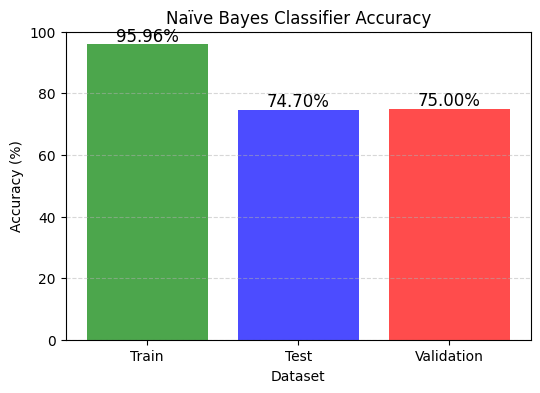

In [ ]:
# Train Naïve Bayes Classifier
nb_classifier = NaiveBayesClassifier()
nb_classifier.fit(X_train, y_train)

# Predict
y_train_pred = nb_classifier.predict(X_train)
y_test_pred = nb_classifier.predict(X_test)
y_val_pred = nb_classifier.predict(X_val)

# Accuracy Calculation
train_accuracy = np.mean(y_train_pred == y_train) * 100
test_accuracy = np.mean(y_test_pred == y_test) * 100
val_accuracy = np.mean(y_val_pred == y_val) * 100

# Print Results
print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")

# Plot Accuracy
plt.figure(figsize=(6, 4))
datasets = ["Train", "Test", "Validation"]
accuracies = [train_accuracy, test_accuracy, val_accuracy]
colors = ["green", "blue", "red"]

plt.bar(datasets, accuracies, color=colors, alpha=0.7)
plt.ylim(0, 100)  # Set y-axis limit to 100%
plt.ylabel("Accuracy (%)")
plt.xlabel("Dataset")
plt.title("Naïve Bayes Classifier Accuracy")

# Label bars with accuracy values
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


In [ ]:
#Applying Feature Selection
def feature_selection_correlation(X, y, top_n=10):
    """
    Selects the top N features with the highest absolute correlation with the target variable y.

    Parameters:
        X (numpy.ndarray): Feature matrix of shape (samples, features).
        y (numpy.ndarray): Target variable of shape (samples,).
        top_n (int): Number of top correlated features to select.

    Returns:
        X_selected (numpy.ndarray): Reduced feature matrix with only the selected features.
        top_features (numpy.ndarray): Indices of selected features.
    """
    # Compute correlation between each feature and the target
    correlation_coeffs = np.array([np.corrcoef(X[:, i], y)[0, 1] for i in range(X.shape[1])])
    correlation_coeffs = np.nan_to_num(correlation_coeffs)

    # Get absolute values and rank features
    top_features = np.argsort(np.abs(correlation_coeffs))[-top_n:]  # Indices of top_n correlated features

    # Select the best features
    X_fs = X[:, top_features]

    return X_fs, top_features


<ipython-input-6-9fa1ba8fe3d0>:26: RuntimeWarning: divide by zero encountered in log
  likelihoods = np.sum(np.log(self.gaussian_pdf(x, self.class_means[cls], self.class_variances[cls])))


Train Accuracy: 35.00%
Test Accuracy: 22.71%
Validation Accuracy: 19.84%


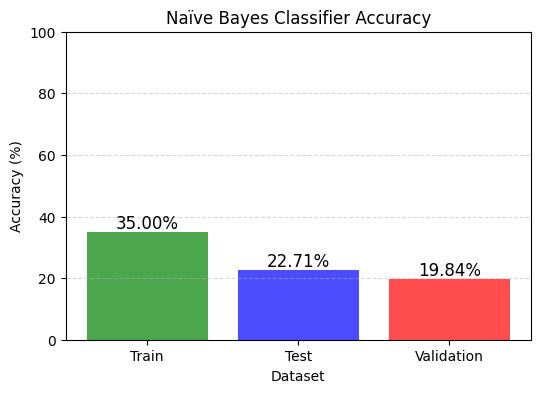

In [ ]:
#Bayesian Using Feature Selection
#Here I am just using a sample value of top_n to get an idea of the model performance.
top_n = 25

X_fs, selected_indices = feature_selection_correlation(X, y, top_n)

X_train, X_temp, y_train, y_temp = train_test_split(X_fs, y, test_size=0.30, random_state=42)  #70% Train
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)  # 10% Val 20% Test


# Train Naïve Bayes Classifier
nb_classifier = NaiveBayesClassifier()
nb_classifier.fit(X_train, y_train)

# Predict
y_train_pred = nb_classifier.predict(X_train)
y_test_pred = nb_classifier.predict(X_test)
y_val_pred = nb_classifier.predict(X_val)

# Accuracy Calculation
train_accuracy = np.mean(y_train_pred == y_train) * 100
test_accuracy = np.mean(y_test_pred == y_test) * 100
val_accuracy = np.mean(y_val_pred == y_val) * 100

# Print Results
print(f"Train Accuracy: {train_accuracy:.2f}%")
print(f"Test Accuracy: {test_accuracy:.2f}%")
print(f"Validation Accuracy: {val_accuracy:.2f}%")

# Plot Accuracy
plt.figure(figsize=(6, 4))
datasets = ["Train", "Test", "Validation"]
accuracies = [train_accuracy, test_accuracy, val_accuracy]
colors = ["green", "blue", "red"]

plt.bar(datasets, accuracies, color=colors, alpha=0.7)
plt.ylim(0, 100)  # Set y-axis limit to 100%
plt.ylabel("Accuracy (%)")
plt.xlabel("Dataset")
plt.title("Naïve Bayes Classifier Accuracy")

# Label bars with accuracy values
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

<ipython-input-6-9fa1ba8fe3d0>:26: RuntimeWarning: divide by zero encountered in log
  likelihoods = np.sum(np.log(self.gaussian_pdf(x, self.class_means[cls], self.class_variances[cls])))


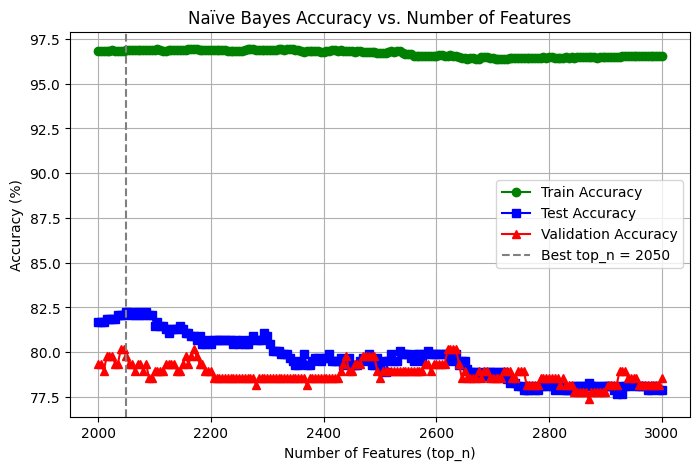

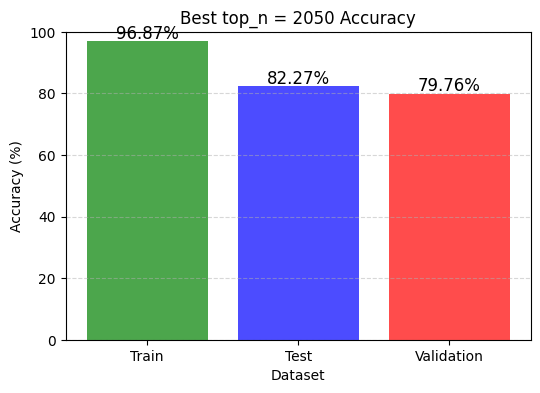

Best top_n: 2050
Best Train Accuracy: 96.87%
Best Test Accuracy: 82.27%
Best Validation Accuracy: 79.76%


In [ ]:
# Define range of top_n values
top_n_values = list(range(2000, 3005, 5))  # Vary from 10 to 50 in steps of 5
train_accuracies = []
test_accuracies = []
val_accuracies = []

best_top_n = None
best_test_accuracy = 0
best_train_acc = 0
best_val_acc = 0

# Iterate over different values of top_n
for top_n in top_n_values:
    X_fs, selected_indices = feature_selection_correlation(X, y, top_n)

    # Split data
    X_train, X_temp, y_train, y_temp = train_test_split(X_fs, y, test_size=0.30, random_state=42)
    X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

    # Train Naïve Bayes Classifier
    nb_classifier = NaiveBayesClassifier()
    nb_classifier.fit(X_train, y_train)

    # Predict
    y_train_pred = nb_classifier.predict(X_train)
    y_test_pred = nb_classifier.predict(X_test)
    y_val_pred = nb_classifier.predict(X_val)

    # Accuracy Calculation
    train_accuracy = np.mean(y_train_pred == y_train) * 100
    test_accuracy = np.mean(y_test_pred == y_test) * 100
    val_accuracy = np.mean(y_val_pred == y_val) * 100

    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    val_accuracies.append(val_accuracy)

    # Update best top_n if test accuracy improves
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        best_top_n = top_n
        best_train_acc = train_accuracy
        best_val_acc = val_accuracy

# Plot accuracy vs. top_n
plt.figure(figsize=(8, 5))
plt.plot(top_n_values, train_accuracies, marker='o', label="Train Accuracy", color="green")
plt.plot(top_n_values, test_accuracies, marker='s', label="Test Accuracy", color="blue")
plt.plot(top_n_values, val_accuracies, marker='^', label="Validation Accuracy", color="red")

plt.axvline(best_top_n, linestyle="--", color="gray", label=f"Best top_n = {best_top_n}")
plt.xlabel("Number of Features (top_n)")
plt.ylabel("Accuracy (%)")
plt.title("Naïve Bayes Accuracy vs. Number of Features")
plt.legend()
plt.grid()
plt.show()

# Bar Chart for Best top_n
plt.figure(figsize=(6, 4))
datasets = ["Train", "Test", "Validation"]
accuracies = [best_train_acc, best_test_accuracy, best_val_acc]
colors = ["green", "blue", "red"]

plt.bar(datasets, accuracies, color=colors, alpha=0.7)
plt.ylim(0, 100)  # Set y-axis limit to 100%
plt.ylabel("Accuracy (%)")
plt.xlabel("Dataset")
plt.title(f"Best top_n = {best_top_n} Accuracy")

# Label bars with accuracy values
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center', fontsize=12)

plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

# Print best top_n and its accuracies
print(f"Best top_n: {best_top_n}")
print(f"Best Train Accuracy: {best_train_acc:.2f}%")
print(f"Best Test Accuracy: {best_test_accuracy:.2f}%")
print(f"Best Validation Accuracy: {best_val_acc:.2f}%")
